In [1]:
## import numpy library
import numpy as np

## import pandas library
import pandas as pd
## set an option for pandas to show max colwidth and better see the data
pd.set_option('display.max_colwidth', None)

## import matplotlib library for visualization
import matplotlib.pyplot as plt
%matplotlib inline

## import to get path
from pathlib import Path

#import os library
import os

#import cv2 library
import cv2

#import imutils library
import imutils

# import LabelEncoder to encode catigorical data 
from sklearn.preprocessing import LabelEncoder

# import utils to shuffel the data
from sklearn import utils

# import train_test_split to split the data
from sklearn.model_selection import train_test_split


## tensorflow & Keras
## tensorflow as tf 
## keras as tf.keras
import tensorflow as tf    

### Prepare the Dataset

In [2]:
## Get the paths of subfolders
# main_paths will have the main paths of folders 

folder_path = os.path.join(os.getcwd(), 'Hijja2')
main_paths = []
for (dirpath, dirnames, filenames) in os.walk(folder_path):
    main_paths.append(dirpath)
    
## remove the outer folders and only keep the inner sub folders
# sub_paths will have the pathes of sub folders 
# labels will have the label of the images
sub_paths = []
labels = []
for sub_folder in main_paths:
    if len(sub_folder.split('\\')) > 6:
        sub_paths.append(sub_folder)
        labels.append(sub_folder.split('\\')[-1])

In [3]:
## Gettinل the Paths and labels for all the Dataset
df_final = pd.DataFrame()

for i in range(len(sub_paths)):
    each_dir = Path(sub_paths[i])
    each_df = pd.DataFrame({'Paths': sorted(each_dir.glob(r'*.png')), 'Labels': labels[i]})
    df_final = pd.concat((df_final, each_df))

In [4]:
## reset index after concatinating the data
df_final = df_final.reset_index().drop(columns=['index'], axis=1)

## shuffle the data set
df_final = utils.shuffle(df_final, random_state=123)
df_final

,Paths,Labels
1720,C:\Users\moham\Desktop\Hijja2\1 alif\1.4\45701.png,1.4
16148,C:\Users\moham\Desktop\Hijja2\18 ayn\18.4\18098.png,18.4
31335,C:\Users\moham\Desktop\Hijja2\26 ha\26.2\9272.png,26.2
35406,C:\Users\moham\Desktop\Hijja2\29 hamza\29.2\26565.png,29.2
19825,C:\Users\moham\Desktop\Hijja2\2 ba\2.4\35103.png,2.4
...,...,...
7763,C:\Users\moham\Desktop\Hijja2\13 shin\13.4\43192.png,13.4
15377,C:\Users\moham\Desktop\Hijja2\18 ayn\18.2\28464.png,18.2
17730,C:\Users\moham\Desktop\Hijja2\19 gayn\19.3\5681.png,19.3
28030,C:\Users\moham\Desktop\Hijja2\24 mim\24.3\28705.png,24.3


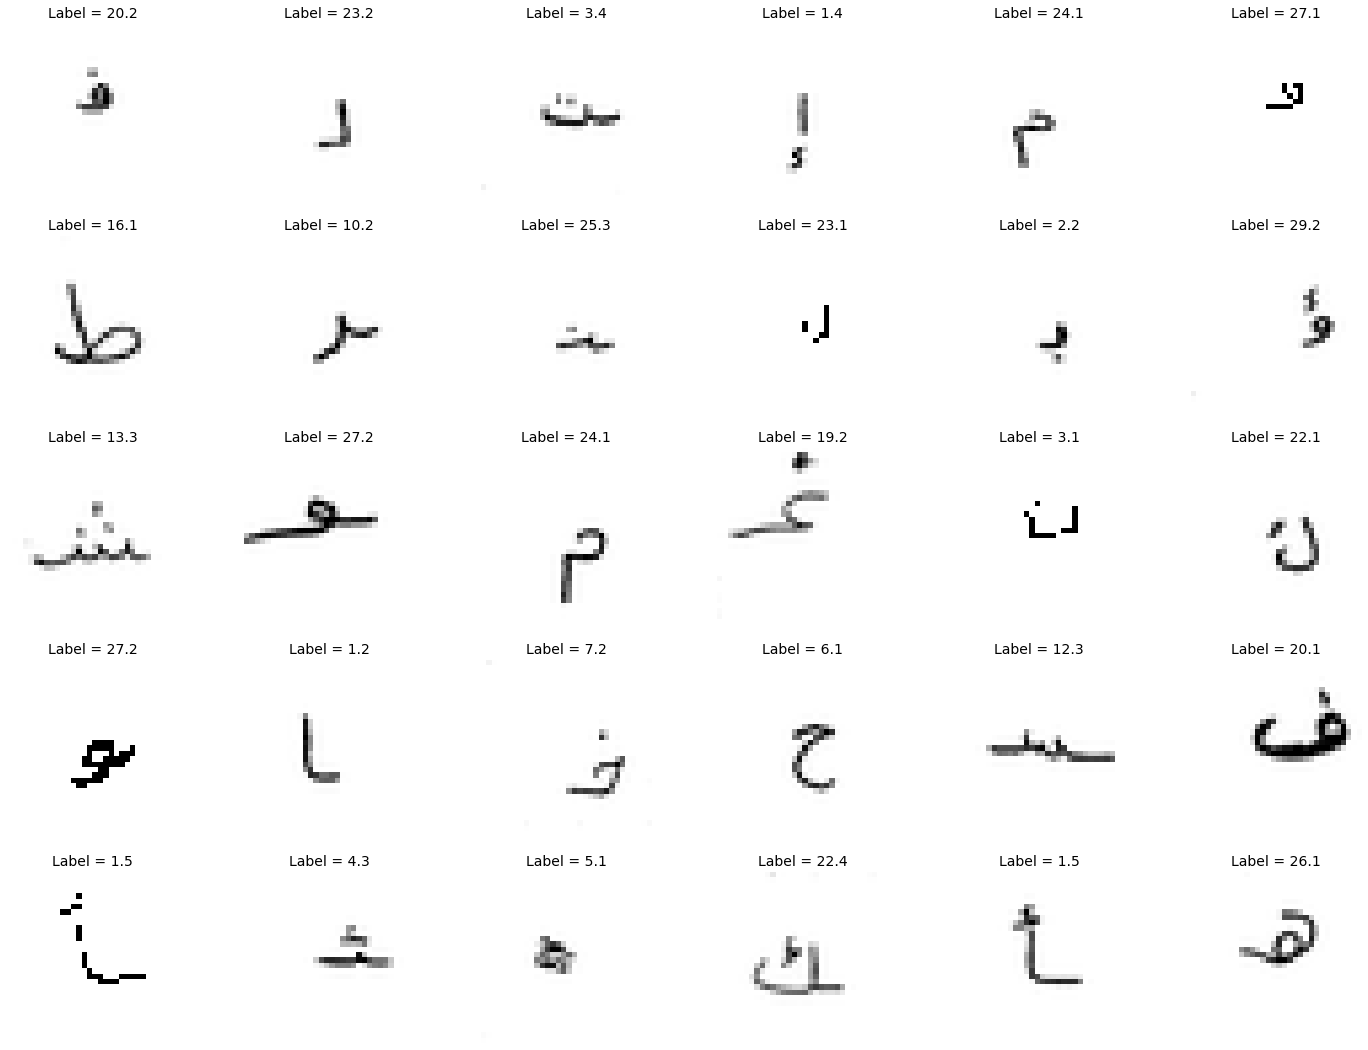

In [5]:
## preparing for plotting random number of images
# choosing the first 30 images 
labels_to_plot = df_final['Labels'].iloc[:30].values 
paths_to_plot = df_final['Paths'].iloc[:30].values

## ploating a sample to the data with label to visualize the data 
fig, ax = plt.subplots(5, 6, figsize=(20, 15))
fig.tight_layout(pad=2)

i = 0
for row in range(5):
    for col in range(6):
        plt.sca(ax[row, col])
        plt.title(f'Label = {labels_to_plot[i]}', fontsize=14)
        img = plt.imread(paths_to_plot[i])
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        i+=1

### Preparing the Dataset before building the Model

In [6]:
## drop more than one channel (non graty images)
to_dropped = []
for idx in range(len(df_final)):
    shapes = plt.imread(df_final['Paths'][idx]).shape
    if shapes != (32, 32):
        to_dropped.append(idx)

In [7]:
## length of images that have more than one channel
print('to_dropped length --> ', len(to_dropped))

to_dropped length -->  41


In [8]:
## drop the images that have more than one channel from the main df
df_final = df_final.drop(to_dropped)

In [9]:
## read the images
data_labels = df_final['Labels'].values
data_images = np.empty((47393, 32, 32), dtype=np.float32)  

for idx, path in enumerate(df_final['Paths']):
    img = plt.imread(path)
    data_images[idx] = img
    
data_images = data_images[..., np.newaxis]  ## add channel of 1
print('data_images.shape =>', data_images.shape)
print('data_labels.shape =>', data_labels.shape)

data_images.shape => (47393, 32, 32, 1)
data_labels.shape => (47393,)


In [10]:
## Label encoding for the target
# encoding the labels of the images 

encoder = LabelEncoder()
data_labels_encoded = encoder.fit_transform(data_labels)

### Split the Data

In [15]:
# spliting the data with 80%:20% train test
X_train, X_valid, y_train, y_valid = train_test_split(data_images, data_labels_encoded, 
                                                      test_size=0.2, shuffle=True, random_state=42)

print('X_train.shape =>', X_train.shape)
print('y_train.shape =>', y_train.shape)
print('X_valid.shape =>', X_valid.shape)
print('y_valid.shape =>', y_valid.shape)

X_train.shape => (37914, 32, 32, 1)
y_train.shape => (37914,)
X_valid.shape => (9479, 32, 32, 1)
y_valid.shape => (9479,)


### Model Training

In [16]:
## build the model
model = tf.keras.models.Sequential([
    
    ## conv base 
    
    ## block_1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same', 
                 activation='elu', input_shape=(32, 32, 1)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='elu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), 
    
    ## block_2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='elu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='elu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    
    ## classifier
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="elu"),
    tf.keras.layers.Dense(256, activation='elu'),
    tf.keras.layers.Dense(108, activation="softmax")
])

## check summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        832       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)             

In [17]:
## compile the model
model.compile(loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'], 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

early_stopp = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True) 

## train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
                    epochs=30, batch_size=32, 
                    callbacks=[early_stopp])

Epoch 1/30
1185/1185 [==============================] - 19s 15ms/step - loss: 9.6595 - accuracy: 0.0087 - val_loss: 5.2233 - val_accuracy: 0.0103
Epoch 2/30
1185/1185 [==============================] - 17s 14ms/step - loss: 5.3705 - accuracy: 0.0097 - val_loss: 5.4208 - val_accuracy: 0.0095
Epoch 3/30
1185/1185 [==============================] - 17s 14ms/step - loss: 5.4852 - accuracy: 0.0094 - val_loss: 5.5335 - val_accuracy: 0.0091
Epoch 4/30
1185/1185 [==============================] - 17s 14ms/step - loss: 5.5932 - accuracy: 0.0089 - val_loss: 5.6163 - val_accuracy: 0.0092
Epoch 5/30
1185/1185 [==============================] - 17s 14ms/step - loss: 5.6826 - accuracy: 0.0094 - val_loss: 5.6996 - val_accuracy: 0.0084
Epoch 6/30
1185/1185 [==============================] - 17s 14ms/step - loss: 5.7477 - accuracy: 0.0088 - val_loss: 5.8442 - val_accuracy: 0.0068


### Segmentation

In [64]:
## sort_contours function : 
#                           to sort the contours of the images and git the bounding boxs
# inputs :
# cnts --> take the countors of the image
# method ---> left-to-right or right-to-left or bottom-to-top or top-to-bottom
# right-to-left or bottom-to-top -----> reverse = True
# return a tuple of (cnts, boundingBoxes)
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [68]:
## get_letters function :
#                         to return the image with letters with bounding box 
# input: 
# img we need to produce the boundingbox in the letters
# return letters as a string , image with boungingboxs around the images 
def get_letters(img):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray ,127, 255, cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="right-to-left")[0]
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1,32,32,1)
        ypred = np.argmax(model.predict(thresh), axis=-1)
        ypred = encoder.inverse_transform(ypred)
        [x] = ypred
        letters.append(x)
    return letters, image

In [69]:
## get_word function :
#                      compine the letters after predicting it 
def get_word(letter):
    word = "".join(letter)
    return word

6.46.46.4


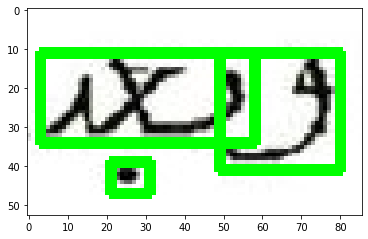

In [70]:
# trying a random image from google 
letter, image = get_letters("e.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)